## 1. 초기 세팅

In [1]:
## 전처리과정에서 pandas의 버전에 다르게 동작하는 경향이 보여, 이 미션에서는 아래 버전으로 사용하도록하겠습니다.
!pip install pandas==1.0.1

     |████████████████████████████████| 10.1 MB 11.5 MB/s 
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.5
    Uninstalling pandas-1.3.5:
      Successfully uninstalled pandas-1.3.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas>=1.1.0; python_version >= "3.0", but you have pandas 1.0.1 which is incompatible.
fbprophet 0.7.1 requires pandas>=1.0.4, but you have pandas 1.0.1 which is incompatible.


In [2]:
import argparse
import time
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt
%matplotlib inline


## 데이터 다운로드
이곳에 대회 사이트(AI Stages)에 있는 data의 URL을 입력해주세요. 
- 데이터 URL은 변경될 수 있습니다.
- 예) `!wget https://aistages-prod-server-public.s3.amazonaws.com/app/Competitions/000176/data/data.tar.gz`

In [3]:
!wget https://aistages-prod-server-public.s3.amazonaws.com/app/Competitions/000176/data/data.tar.gz
!tar -xf data.tar.gz

--2022-03-31 01:29:08--  https://aistages-prod-server-public.s3.amazonaws.com/app/Competitions/000176/data/data.tar.gz
Resolving aistages-prod-server-public.s3.amazonaws.com (aistages-prod-server-public.s3.amazonaws.com)... 52.218.132.27
Connecting to aistages-prod-server-public.s3.amazonaws.com (aistages-prod-server-public.s3.amazonaws.com)|52.218.132.27|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 33424489 (32M) [binary/octet-stream]
Saving to: ‘data.tar.gz’

data.tar.gz         100%[===================>]  31.88M  11.3MB/s    in 2.8s    

2022-03-31 01:29:11 (11.3 MB/s) - ‘data.tar.gz’ saved [33424489/33424489]

tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.dropbox.attrs'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.quarantine'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.dropbox.attrs'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.quarantine'
tar: Ignori

In [4]:
import pandas as pd
import numpy as np

In [5]:
## 각종 파라미터 세팅
parser = argparse.ArgumentParser(description='PyTorch Variational Autoencoders for Collaborative Filtering')


parser.add_argument('--data', type=str, default='data/train/',
                    help='Movielens dataset location')

parser.add_argument('--lr', type=float, default=1e-4,
                    help='initial learning rate')
parser.add_argument('--wd', type=float, default=0.00,
                    help='weight decay coefficient')
parser.add_argument('--batch_size', type=int, default=1600,#500,
                    help='batch size')
parser.add_argument('--epochs', type=int, default=20, #원래 20
                    help='upper epoch limit')
parser.add_argument('--total_anneal_steps', type=int, default=200000,
                    help='the total number of gradient updates for annealing')
parser.add_argument('--anneal_cap', type=float, default=0.2,
                    help='largest annealing parameter')
parser.add_argument('--seed', type=int, default=1111,
                    help='random seed')
parser.add_argument('--cuda', action='store_true',
                    help='use CUDA')
parser.add_argument('--log_interval', type=int, default=100, metavar='N',
                    help='report interval')
parser.add_argument('--save', type=str, default='model.pt',
                    help='path to save the final model')
args = parser.parse_args([])

# Set the random seed manually for reproductibility.
torch.manual_seed(args.seed)

#만약 GPU가 사용가능한 환경이라면 GPU를 사용
if torch.cuda.is_available():
    args.cuda = True

device = torch.device("cuda" if args.cuda else "cpu")
device

device(type='cuda')

##2. 데이터 전처리

이 부분에서 진행되는 과정은 저희가 일반적으로 알고있는 MovieLens (user, item, timestamp)데이터를 전처리하는 과정입니다. 전처리 과정의 다양한 옵션들을 구성하기 위해 약간 복잡하게 되었지만, 
결과적으로는, 유저들의 특정한 아이템들을 따로 분리를 해서, 그 분리된 값을 모델이 예측할 수 있냐를 확인하기 위한 전처리 과정이라고 보시면 되겠습니다.
실제로 나오는 데이터셋을 확인하면 더욱 이해가 빠를것입니다.

In [6]:
import os
import pandas as pd
from scipy import sparse
import numpy as np

def get_count(tp, id):
    playcount_groupbyid = tp[[id]].groupby(id, as_index=False)
    count = playcount_groupbyid.size()

    return count

# 특정한 횟수 이상의 리뷰가 존재하는(사용자의 경우 min_uc 이상, 아이템의 경우 min_sc이상) 
# 데이터만을 추출할 때 사용하는 함수입니다.
# 현재 데이터셋에서는 결과적으로 원본그대로 사용하게 됩니다.
def filter_triplets(tp, min_uc=5, min_sc=0):
    if min_sc > 0:
        itemcount = get_count(tp, 'item')
        tp = tp[tp['item'].isin(itemcount.index[itemcount >= min_sc])]

    if min_uc > 0:
        usercount = get_count(tp, 'user')
        tp = tp[tp['user'].isin(usercount.index[usercount >= min_uc])]

    usercount, itemcount = get_count(tp, 'user'), get_count(tp, 'item')
    return tp, usercount, itemcount

#훈련된 모델을 이용해 검증할 데이터를 분리하는 함수입니다.
#100개의 액션이 있다면, 그중에 test_prop 비율 만큼을 비워두고, 그것을 모델이 예측할 수 있는지를
#확인하기 위함입니다.
def split_train_test_proportion(data, test_prop=0.2): #원래 0.2
    data_grouped_by_user = data.groupby('user')
    tr_list, te_list = list(), list()

    np.random.seed(98765)
    
    for _, group in data_grouped_by_user:
        n_items_u = len(group)
        
        if n_items_u >= 5:
            idx = np.zeros(n_items_u, dtype='bool')
            idx[np.random.choice(n_items_u, size=int(test_prop * n_items_u), replace=False).astype('int64')] = True

            tr_list.append(group[np.logical_not(idx)])
            te_list.append(group[idx])
        
        else:
            tr_list.append(group)
    
    data_tr = pd.concat(tr_list)
    data_te = pd.concat(te_list)

    return data_tr, data_te

def numerize(tp, profile2id, show2id):
    uid = tp['user'].apply(lambda x: profile2id[x])
    sid = tp['item'].apply(lambda x: show2id[x])
    return pd.DataFrame(data={'uid': uid, 'sid': sid}, columns=['uid', 'sid'])

In [7]:
print("Load and Preprocess Movielens dataset")
# Load Data
DATA_DIR = args.data
raw_data = pd.read_csv(os.path.join(DATA_DIR, 'train_ratings.csv'), header=0)
print("원본 데이터\n", raw_data)

# Filter Data
raw_data, user_activity, item_popularity = filter_triplets(raw_data, min_uc=5, min_sc=0)
#제공된 훈련데이터의 유저는 모두 5개 이상의 리뷰가 있습니다.
print("5번 이상의 리뷰가 있는 유저들로만 구성된 데이터\n",raw_data)

print("유저별 리뷰수\n",user_activity)
print("아이템별 리뷰수\n",item_popularity)

Load and Preprocess Movielens dataset
원본 데이터
            user   item        time
0            11   4643  1230782529
1            11    170  1230782534
2            11    531  1230782539
3            11    616  1230782542
4            11   2140  1230782563
...         ...    ...         ...
5154466  138493  44022  1260209449
5154467  138493   4958  1260209482
5154468  138493  68319  1260209720
5154469  138493  40819  1260209726
5154470  138493  27311  1260209807

[5154471 rows x 3 columns]
5번 이상의 리뷰가 있는 유저들로만 구성된 데이터
            user   item        time
0            11   4643  1230782529
1            11    170  1230782534
2            11    531  1230782539
3            11    616  1230782542
4            11   2140  1230782563
...         ...    ...         ...
5154466  138493  44022  1260209449
5154467  138493   4958  1260209482
5154468  138493  68319  1260209720
5154469  138493  40819  1260209726
5154470  138493  27311  1260209807

[5154471 rows x 3 columns]
유저별 리뷰수
 user
11        376
1

In [8]:
# Shuffle User Indices
unique_uid = user_activity.index
print("(BEFORE) unique_uid:",unique_uid)
np.random.seed(98765)
idx_perm = np.random.permutation(unique_uid.size)
unique_uid = unique_uid[idx_perm]
print("(AFTER) unique_uid:",unique_uid)

n_users = unique_uid.size #31360
n_heldout_users = 3136#3000


# Split Train/Validation/Test User Indices
tr_users = unique_uid[:(n_users - n_heldout_users * 2)]
vd_users = unique_uid[(n_users - n_heldout_users * 2): (n_users - n_heldout_users)]
te_users = unique_uid[(n_users - n_heldout_users):]

#주의: 데이터의 수가 아닌 사용자의 수입니다!
print("훈련 데이터에 사용될 사용자 수:", len(tr_users))
print("검증 데이터에 사용될 사용자 수:", len(vd_users))
print("테스트 데이터에 사용될 사용자 수:", len(te_users))



(BEFORE) unique_uid: Int64Index([    11,     14,     18,     25,     31,     35,     43,     50,
                58,     60,
            ...
            138459, 138461, 138470, 138471, 138472, 138473, 138475, 138486,
            138492, 138493],
           dtype='int64', name='user', length=31360)
(AFTER) unique_uid: Int64Index([ 27968,  67764,   2581,  82969, 137831,  48639,  97870,  40424,
             46835,  79570,
            ...
            114284,   9009,  21165,  33920,  22054, 135379, 125855,  41891,
             15720,  17029],
           dtype='int64', name='user', length=31360)
훈련 데이터에 사용될 사용자 수: 25088
검증 데이터에 사용될 사용자 수: 3136
테스트 데이터에 사용될 사용자 수: 3136


In [ ]:
#import pickle
#with open('show2id.pkl', 'wb') as f:
#    pickle.dump(show2id, f)

#with open('profile2id.pkl', 'wb') as f:
#    pickle.dump(profile2id, f)


In [10]:
##훈련 데이터에 해당하는 아이템들
#Train에는 전체 데이터를 사용합니다.
train_plays = raw_data.loc[raw_data['user'].isin(tr_users)]

##아이템 ID
unique_sid = pd.unique(train_plays['item'])

show2id = dict((sid, i) for (i, sid) in enumerate(unique_sid))
profile2id = dict((pid, i) for (i, pid) in enumerate(unique_uid))

pro_dir = os.path.join(DATA_DIR, 'pro_sg')

if not os.path.exists(pro_dir):
    os.makedirs(pro_dir)

with open(os.path.join(pro_dir, 'unique_sid.txt'), 'w') as f:
    for sid in unique_sid:
        f.write('%s\n' % sid)

#Validation과 Test에는 input으로 사용될 tr 데이터와 정답을 확인하기 위한 te 데이터로 분리되었습니다.
vad_plays = raw_data.loc[raw_data['user'].isin(vd_users)]
vad_plays = vad_plays.loc[vad_plays['item'].isin(unique_sid)]
vad_plays_tr, vad_plays_te = split_train_test_proportion(vad_plays)

test_plays = raw_data.loc[raw_data['user'].isin(te_users)]
test_plays = test_plays.loc[test_plays['item'].isin(unique_sid)]
test_plays_tr, test_plays_te = split_train_test_proportion(test_plays)



train_data = numerize(train_plays, profile2id, show2id)
train_data.to_csv(os.path.join(pro_dir, 'train.csv'), index=False)


vad_data_tr = numerize(vad_plays_tr, profile2id, show2id)
vad_data_tr.to_csv(os.path.join(pro_dir, 'validation_tr.csv'), index=False)

vad_data_te = numerize(vad_plays_te, profile2id, show2id)
vad_data_te.to_csv(os.path.join(pro_dir, 'validation_te.csv'), index=False)

test_data_tr = numerize(test_plays_tr, profile2id, show2id)
test_data_tr.to_csv(os.path.join(pro_dir, 'test_tr.csv'), index=False)

test_data_te = numerize(test_plays_te, profile2id, show2id)
test_data_te.to_csv(os.path.join(pro_dir, 'test_te.csv'), index=False)

print("Done!")

Done!


In [11]:
#데이터 셋 확인
print(train_data)
print(vad_data_tr)
print(vad_data_te)
# print(test_data_tr)
# print(test_data_te)

           uid   sid
0        11825     0
1        11825     1
2        11825     2
3        11825     3
4        11825     4
...        ...   ...
5154466  10783   477
5154467  10783  1325
5154468  10783   331
5154469  10783   558
5154470  10783  1922

[4125303 rows x 2 columns]
           uid   sid
376      26554   440
377      26554   741
378      26554  1407
379      26554   193
380      26554  1041
...        ...   ...
5153247  26934   760
5153248  26934   697
5153249  26934  3232
5153250  26934  1369
5153251  26934  3679

[415395 rows x 2 columns]
           uid   sid
382      26554  3012
383      26554  1681
384      26554   201
399      26554  3177
401      26554  3289
...        ...   ...
5153229  26934   737
5153233  26934   228
5153236  26934   235
5153240  26934  3962
5153243  26934  1086

[102295 rows x 2 columns]


##3. 데이터 로더 설정

In [24]:
latent = 80
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.svds.html
from scipy.sparse.linalg import svds

class DataLoader():
    '''
    Load Movielens dataset
    '''
    def __init__(self, path):
        
        self.pro_dir = os.path.join(path, 'pro_sg')
        assert os.path.exists(self.pro_dir), "Preprocessed files do not exist. Run data.py"

        self.n_items = self.load_n_items()
    
    def load_data(self, datatype='train'):
        if datatype == 'train':
            return self._load_train_data()
        elif datatype == 'validation':
            return self._load_tr_te_data(datatype)
        elif datatype == 'test':
            return self._load_tr_te_data(datatype)
        else:
            raise ValueError("datatype should be in [train, validation, test]")
        
    def load_n_items(self):
        unique_sid = list()
        with open(os.path.join(self.pro_dir, 'unique_sid.txt'), 'r') as f:
            for line in f:
                unique_sid.append(line.strip())
        n_items = len(unique_sid)
        return n_items
    
    def _load_train_data(self):
        path = os.path.join(self.pro_dir, 'train.csv')
        
        tp = pd.read_csv(path)
        n_users = tp['uid'].max() + 1

        rows, cols = tp['uid'], tp['sid']
        data = sparse.csr_matrix((np.ones_like(rows),
                                 (rows, cols)), dtype='float64',
                                 shape=(n_users, self.n_items))

        #data_U, data_sigma, data_Vt = svds(data, k=latent) ######추가
        #data = torch.concat([torch.from_numpy(data_U).float(), torch.from_numpy(data_Vt).float().T], 0)
        return data
    
    def _load_tr_te_data(self, datatype='test'):
        tr_path = os.path.join(self.pro_dir, '{}_tr.csv'.format(datatype))
        te_path = os.path.join(self.pro_dir, '{}_te.csv'.format(datatype))

        tp_tr = pd.read_csv(tr_path)
        tp_te = pd.read_csv(te_path)

        start_idx = min(tp_tr['uid'].min(), tp_te['uid'].min())
        end_idx = max(tp_tr['uid'].max(), tp_te['uid'].max())

        rows_tr, cols_tr = tp_tr['uid'] - start_idx, tp_tr['sid']
        rows_te, cols_te = tp_te['uid'] - start_idx, tp_te['sid']

        data_tr = sparse.csr_matrix((np.ones_like(rows_tr),
                                    (rows_tr, cols_tr)), dtype='float64', shape=(end_idx - start_idx + 1, self.n_items))
        data_te = sparse.csr_matrix((np.ones_like(rows_te),
                                    (rows_te, cols_te)), dtype='float64', shape=(end_idx - start_idx + 1, self.n_items))
        
        #tr_U, tr_sigma, tr_Vt = svds(data_tr, k=latent)
        #vad_data = torch.concat([torch.from_numpy(tr_U).float(), torch.from_numpy(tr_Vt).float().T], 0)
        #te_U, te_sigma, te_Vt = svds(data_te, k=latent)
        #test_data = torch.concat([torch.from_numpy(te_U).float(), torch.from_numpy(te_Vt).float().T], 0)

        return data_tr, data_te

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch
import numpy as np

# scipy-svd

In [28]:
def Recall_at_k_batch(X_pred, heldout_batch, k=100):    
    batch_users = X_pred.shape[0]

    idx = bn.argpartition(-X_pred, k, axis=1)
    X_pred_binary = np.zeros_like(X_pred, dtype=bool)

    X_pred_binary[np.arange(batch_users)[:, np.newaxis], idx[:, :k]] = True

    X_true_binary = (heldout_batch > 0).toarray()
    tmp = (np.logical_and(X_true_binary, X_pred_binary).sum(axis=1)).astype(
        np.float32)
    recall = tmp / np.minimum(k, X_true_binary.sum(axis=1))
    return recall

In [25]:
loader = DataLoader(args.data)

n_items = loader.load_n_items()
train_data = loader.load_data('train')
vad_data_tr, vad_data_te = loader.load_data('validation')
test_data_tr, test_data_te = loader.load_data('test')

In [26]:
vad_data_tr.shape

(3136, 6807)

In [52]:
import bottleneck as bn

latent = 7

vad_U, vad_sigma, vad_Vt = svds(vad_data_tr, k=latent, which='LM', maxiter=500, solver='arpack')
X_pred = torch.matmul(torch.tensor(vad_U), torch.tensor(vad_Vt))
print(np.mean(Recall_at_k_batch(X_pred, vad_data_te, k=10)))


test_U, test_sigma, test_Vt = svds(test_data_tr, k=latent, which='LM', maxiter=500, solver='arpack')
X_pred = torch.matmul(torch.tensor(test_U), torch.tensor(test_Vt))
print(np.mean(Recall_at_k_batch(X_pred, test_data_te, k=10)))


0.12475552721088436
0.12145868764172338


In [53]:
## 배치사이즈 미포함
def numerize_for_infer(tp, profile2id, show2id):
    uid = tp['user'].apply(lambda x: profile2id[x])
    sid = tp['item'].apply(lambda x: show2id[x])
    return pd.DataFrame(data={'uid': uid, 'sid': sid}, columns=['uid', 'sid'])

### 데이터 준비    
infer_df = numerize_for_infer(raw_data, profile2id, show2id)

loader = DataLoader(args.data)
n_items = loader.load_n_items()

n_users = infer_df['uid'].max() + 1

rows, cols = infer_df['uid'], infer_df['sid']
data = sparse.csr_matrix((np.ones_like(rows),
                                 (rows, cols)), dtype='float64',
                                 shape=(n_users, n_items))

N = data.shape[0]
idxlist = list(range(N))

#https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.svds.html
from scipy.sparse.linalg import svds
te_U, te_sigma, te_Vt = svds(data, k=latent)

X_pred = torch.matmul(torch.tensor(te_U), torch.tensor(te_Vt))
X_pred[data.toarray() > 0] = -np.inf
idx = bn.argpartition(-X_pred, 10, axis=1)[:, :10]


### sample_submission 형태로 바꾸고 id 다시 바꾸기
user = []
item = []
for i_idx, arr_10 in enumerate(idx):
    user.extend([i_idx]*10)
    item.extend(arr_10)

u = pd.DataFrame(user, columns=['user'])
i = pd.DataFrame(item, columns=['item'])
all = pd.concat([u, i], axis=1)

re_p2id = dict((v, k) for k, v in profile2id.items())
re_s2id = dict((v, k) for k, v in show2id.items())

def de_numerize(tp, re_p2id, re_s2id):
    uid = tp['user'].apply(lambda x: re_p2id[x])
    sid = tp['item'].apply(lambda x: re_s2id[x])
    return pd.DataFrame(data={'uid': uid, 'sid': sid}, columns=['uid', 'sid'])

ans = de_numerize(all, re_p2id, re_s2id)
ans.columns = ['user', 'item']
new_ans = ans.sort_values('user')

### 확인용
#submit_data = pd.read_csv('/content/data/eval/sample_submission.csv', sep='\t')
#sum(new_ans2.user.values == submit_data.user.values)
new_ans.reset_index(drop=True, inplace=True)
new_ans.to_csv('0331_submit.csv', index=False)

In [55]:
a = pd.read_csv('0331_submit.csv')


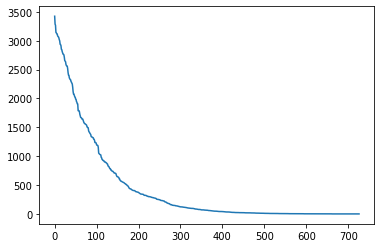

In [57]:
plt.plot(a['item'].value_counts().values)

In [59]:
a['item'].isnull().sum()

0